In [ ]:
# CELL 1: Import Libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, F1Score # F1Score for TensorFlow Addons or newer TF
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt
import os

try: 
    from tensorflow.keras.metrics import F1Score
    f1_score_metric = F1Score(average='macro', name='f1_score')
except ImportError:
    print("F1Score not found in tf.keras.metrics. Consider TensorFlow Addons or a custom implementation.")
    from tensorflow.keras.metrics import Precision, Recall
    f1_score_metric = [Precision(name='precision'), Recall(name='recall')] # Fallback

In [2]:
# CELL 2: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# CELL 3: Define Constants and Paths
# REMEMBER PLS! ADJUST THIS PATH to where 'corn_train/train' directory is in Google Drive
TRAIN_DIR = '/content/drive/MyDrive/corn_train/train'

IMG_SIZE = (256, 256)
IMG_WIDTH = 260
IMG_HEIGHT = 260
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3) # For EfficientNetV2B2

NUM_CLASSES = 4 # Blight, Common_Rust, Gray_Leaf_Spot, Healthy
BATCH_SIZE = 32 # Adjust based on Colab GPU memory
SEED = 123

In [4]:
# CELL 4: Load and Preprocess Dataset
# Using image_dataset_from_directory, which is convenient.
# It infers class names from directory structure.
# It loads images as tf.data.Dataset objects.

# Note: For using class_weights with to_categorical labels, we need to one-hot encode them.
# image_dataset_from_directory by default uses 'int' labels so we'll change this.
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset='training',
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical'  # 'categorical' for one-hot encoded labels
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset='validation',
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

class_names = train_ds.class_names
print("Class names:", class_names)
print(f"Number of classes: {NUM_CLASSES}")

# Verify dataset loading
for images, labels in train_ds.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape) # Should be (batch_size, num_classes)

Found 3360 files belonging to 4 classes.
Using 2688 files for training.
Found 3360 files belonging to 4 classes.
Using 672 files for validation.
Class names: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']
Number of classes: 4
Images shape: (32, 260, 260, 3)
Labels shape: (32, 4)


In [5]:
# CELL 5: Calculate Class Weights to Address Imbalance
# Summary of counts per class:
# Blight: 917
# Common_Rust: 1045
# Gray_Leaf_Spot: 459
# Healthy: 929
# Total: 3350

# Using user-provided counts:
counts = {
    'Blight': 917,
    'Common_Rust': 1045,
    'Gray_Leaf_Spot': 459,
    'Healthy': 929
}

# Ensure class_names order matches the counts order
# The order from image_dataset_from_directory is alphabetical
# Blight, Common_Rust, Gray_Leaf_Spot, Healthy
class_order_from_counts = ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']
if class_names != class_order_from_counts:
    print(f"Warning: Class order mismatch. Dataset loader order: {class_names}, Counts order: {class_order_from_counts}")
    print("Re-ordering counts to match dataset loader if necessary or ensure directory names match counts keys.")

ordered_counts = np.array([counts[name] for name in class_names])

total_samples = np.sum(ordered_counts)
class_weights_calculated = {}
for i, class_name in enumerate(class_names):
    weight = total_samples / (NUM_CLASSES * ordered_counts[i])
    class_weights_calculated[i] = weight

print("Calculated Class Weights:", class_weights_calculated)

Calculated Class Weights: {0: np.float64(0.9133042529989095), 1: np.float64(0.8014354066985646), 2: np.float64(1.8246187363834423), 3: np.float64(0.9015069967707212)}


In [6]:
# CELL 6: Configure Dataset for Performance
AUTOTUNE = tf.data.AUTOTUNE

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000, seed=SEED) # Add shuffle here
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds) # Only cache and prefetch for validation
# No need to shuffle val_ds

In [7]:
# CELL 7: Data Augmentation and Preprocessing Layer for EfficientNetV2
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical', seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),
    layers.RandomZoom(0.2, seed=SEED),
    layers.RandomContrast(0.2, seed=SEED),
    # layers.Rescaling(1./255)
], name='data_augmentation')

In [8]:
# CELL 8: Build the Model using Transfer Learning with EfficientNetV2B2

# Load EfficientNetV2B2 without top layer
# Ensure input_shape matches IMG_SHAPE
base_model_efficientnet = EfficientNetV2B2(
    input_shape=IMG_SHAPE,
    include_top=False,      # Do not include the ImageNet classifier at the top.
    weights='imagenet',     # Load weights pre-trained on ImageNet.
    pooling='avg'           # Global average pooling before the custom classifier
)

# Freeze the base model initially
base_model_efficientnet.trainable = False

# Create the new model on top
inputs = tf.keras.Input(shape=IMG_SHAPE, name='input_layer')
x = data_augmentation(inputs)
# x = efficientnet_preprocess_input(x) # Use if specific preprocessing is required for EfficientNetV2
                                      # For now, we assume data_augmentation outputs [0,255]
                                      # and EfficientNetV2B2 handles it or has internal rescaling.
x = base_model_efficientnet(x, training=False) # Pass `training=False` when base_model is frozen
# The pooling='avg' in base_model definition already applied GlobalAveragePooling2D
# x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x) # Not needed if pooling='avg' in base
x = layers.BatchNormalization(name='batch_norm_top')(x) # Optional: Batch norm before dropout
x = layers.Dropout(0.3, name='top_dropout')(x) # Increased dropout slightly
outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='output_layer')(x)

model_efficientnet = tf.keras.Model(inputs, outputs)

# Compile the model
# Using CategoricalCrossentropy because labels are one-hot encoded
# Using F1Score (macro average) as the primary metric.

metrics_to_use = ['categorical_accuracy']
if isinstance(f1_score_metric, list): # Fallback to Precision and Recall
    metrics_to_use.extend(f1_score_metric)
else: # Use F1Score directly
    metrics_to_use.append(f1_score_metric)


model_efficientnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Initial LR
    loss=CategoricalCrossentropy(),
    metrics=metrics_to_use
)

model_efficientnet.summary()

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 1408)           │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_top                  │ (None, 1408)           │         5,632 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout (Dropout)           │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 4)              │         5,636 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,780,642 (33.50 MB)

 Trainable params: 8,452 (33.02 KB)

 Non-trainable params: 8,772,190 (33.46 MB)

In [9]:
# CELL 9: Define Callbacks
early_stopping = EarlyStopping(
    monitor='val_f1_score' if not isinstance(f1_score_metric, list) else 'val_recall', # Monitor val_f1_score or val_recall as proxy
    patience=10,
    verbose=1,
    mode='max', # For F1 score, recall, accuracy, 'max' is appropriate
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_f1_score' if not isinstance(f1_score_metric, list) else 'val_recall',
    factor=0.2,
    patience=5,
    verbose=1,
    mode='max',
    min_lr=1e-7
)

callbacks_list = [early_stopping, reduce_lr]

In [10]:
# CELL 10: Initial Training (Train only the top layers)
EPOCHS_INITIAL = 20 # Start with more epochs for the head

print("--- Initial Training (Top Layers) ---")
history_efficientnet_initial = model_efficientnet.fit(
    train_ds,
    epochs=EPOCHS_INITIAL,
    validation_data=val_ds,
    callbacks=callbacks_list,
    class_weight=class_weights_calculated # Apply class weights
)

--- Initial Training (Top Layers) ---
Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 172s 441ms/step - categorical_accuracy: 0.6524 - f1_score: 0.6247 - loss: 1.0273 - val_categorical_accuracy: 0.7946 - val_f1_score: 0.7746 - val_loss: 0.5686 - learning_rate: 0.0010
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - categorical_accuracy: 0.8638 - f1_score: 0.8411 - loss: 0.4243 - val_categorical_accuracy: 0.8720 - val_f1_score: 0.8558 - val_loss: 0.3762 - learning_rate: 0.0010
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - categorical_accuracy: 0.8803 - f1_score: 0.8562 - loss: 0.3741 - val_categorical_accuracy: 0.9182 - val_f1_score: 0.9027 - val_loss: 0.2746 - learning_rate: 0.0010
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - categorical_accuracy: 0.8938 - f1_score: 0.8705 - loss: 0.3188 - val_categorical_accuracy: 0.9077 - val_f1_score: 0.8911 - val_loss: 0.2745 - learning_rate: 0.0010
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - categorical_accuracy: 0.9069 - f1_scor

In [ ]:
# CELL 11: Fine-Tuning (Unfreeze some layers of the base model)

# Unfreeze the base model or part of it
base_model_efficientnet.trainable = True

# Fine-tune from this layer onwards
# Unfreeze from around 80% of layers
fine_tune_at = int(len(base_model_efficientnet.layers) * 0.80) # Adjust later (try less or more later)

for layer in base_model_efficientnet.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model_efficientnet.layers[fine_tune_at:]:
    layer.trainable = True


# Re-compile the model with a very low learning rate for fine-tuning
model_efficientnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # Much lower LR for fine-tuning
    loss=CategoricalCrossentropy(),
    metrics=metrics_to_use
)

model_efficientnet.summary() # Check trainable params

EPOCHS_FINE_TUNE = 15 # Additional epochs for fine-tuning
total_epochs = EPOCHS_INITIAL + EPOCHS_FINE_TUNE

print("--- Fine-Tuning ---")
history_efficientnet_fine_tune = model_efficientnet.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history_efficientnet_initial.epoch[-1] + 1, # Start from where initial training left off
    validation_data=val_ds,
    callbacks=callbacks_list, # Can reuse or adjust callbacks for fine-tuning
    class_weight=class_weights_calculated
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 1408)           │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_top                  │ (None, 1408)           │         5,632 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout (Dropout)           │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 4)              │         5,636 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,780,642 (33.50 MB)

 Trainable params: 3,297,876 (12.58 MB)

 Non-trainable params: 5,482,766 (20.92 MB)

--- Fine-Tuning ---
Epoch 21/35
84/84 ━━━━━━━━━━━━━━━━━━━━ 35s 108ms/step - categorical_accuracy: 0.8839 - f1_score: 0.8872 - loss: 0.3290 - val_categorical_accuracy: 0.9301 - val_f1_score: 0.9140 - val_loss: 0.1973 - learning_rate: 1.0000e-05
Epoch 22/35
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - categorical_accuracy: 0.9027 - f1_score: 0.8864 - loss: 0.2973 - val_categorical_accuracy: 0.9271 - val_f1_score: 0.9128 - val_loss: 0.1963 - learning_rate: 1.0000e-05
Epoch 23/35
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - categorical_accuracy: 0.8994 - f1_score: 0.8753 - loss: 0.3002 - val_categorical_accuracy: 0.9330 - val_f1_score: 0.9185 - val_loss: 0.1813 - learning_rate: 1.0000e-05
Epoch 24/35
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - categorical_accuracy: 0.9151 - f1_score: 0.8957 - loss: 0.2735 - val_categorical_accuracy: 0.9330 - val_f1_score: 0.9190 - val_loss: 0.1809 - learning_rate: 1.0000e-05
Epoch 25/35
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - categorical_accuracy: 0.9124 - f1_sc

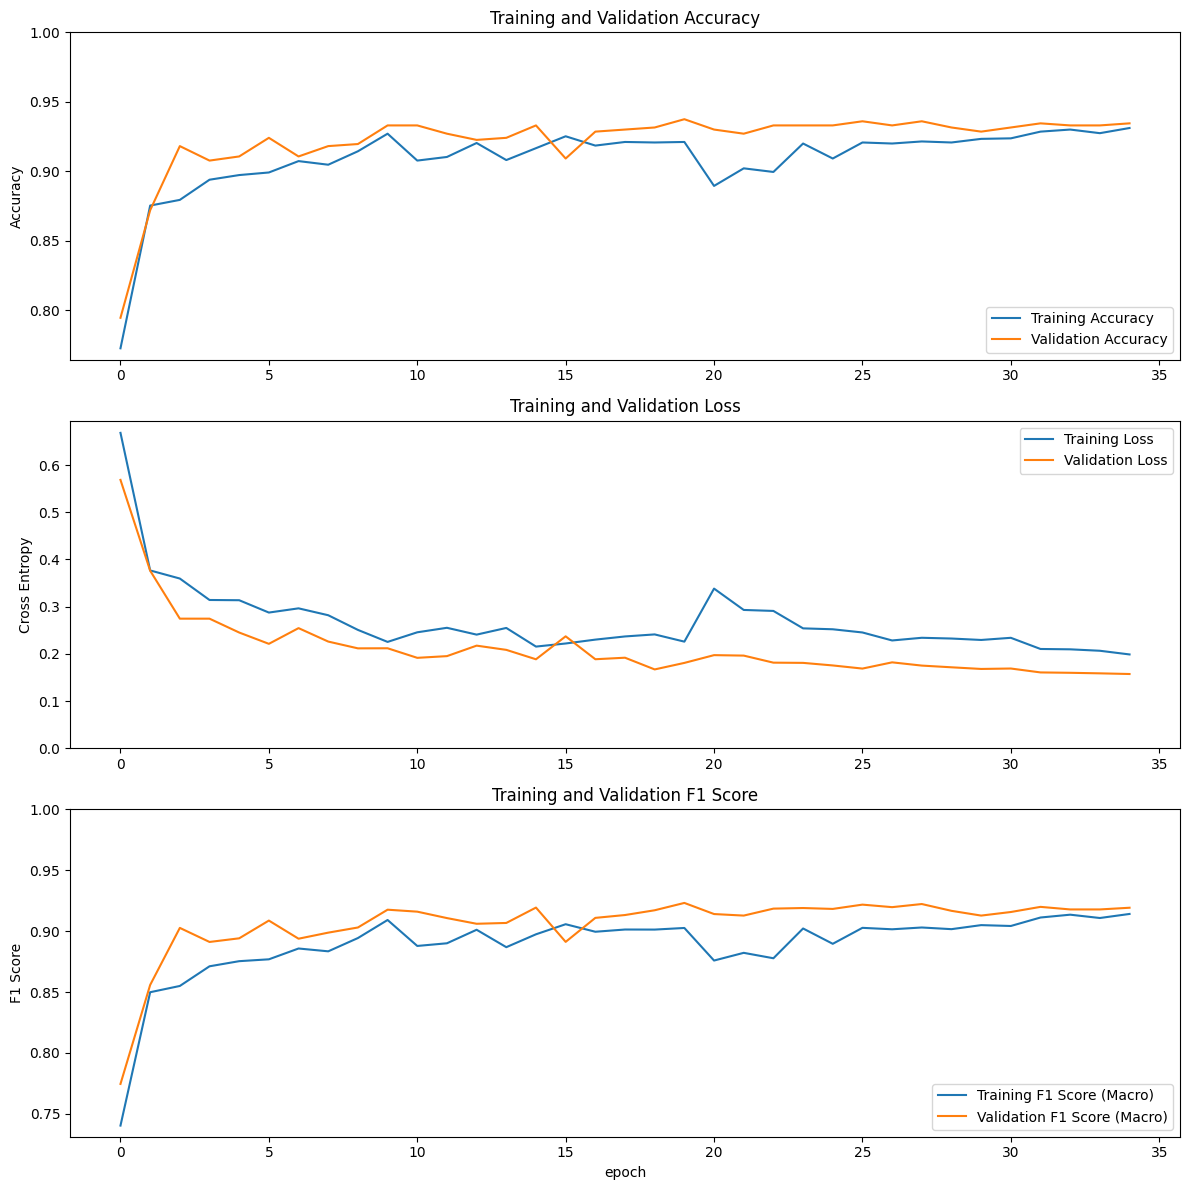

In [12]:
# CELL 12: Plot Training History (Accuracy, Loss, F1 Score if available)

acc = history_efficientnet_initial.history['categorical_accuracy'] + history_efficientnet_fine_tune.history['categorical_accuracy']
val_acc = history_efficientnet_initial.history['val_categorical_accuracy'] + history_efficientnet_fine_tune.history['val_categorical_accuracy']

loss = history_efficientnet_initial.history['loss'] + history_efficientnet_fine_tune.history['loss']
val_loss = history_efficientnet_initial.history['val_loss'] + history_efficientnet_fine_tune.history['val_loss']

# Plot F1 score if available, otherwise Precision and Recall
if 'f1_score' in history_efficientnet_initial.history:
    f1 = history_efficientnet_initial.history['f1_score'] + history_efficientnet_fine_tune.history['f1_score']
    val_f1 = history_efficientnet_initial.history['val_f1_score'] + history_efficientnet_fine_tune.history['val_f1_score']
else: # Plot Precision and Recall
    precision = history_efficientnet_initial.history['precision'] + history_efficientnet_fine_tune.history['precision']
    val_precision = history_efficientnet_initial.history['val_precision'] + history_efficientnet_fine_tune.history['val_precision']
    recall = history_efficientnet_initial.history['recall'] + history_efficientnet_fine_tune.history['recall']
    val_recall = history_efficientnet_initial.history['val_recall'] + history_efficientnet_fine_tune.history['val_recall']


plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(3, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')


if 'f1_score' in history_efficientnet_initial.history:
    plt.subplot(3, 1, 3)
    plt.plot(f1, label='Training F1 Score (Macro)')
    plt.plot(val_f1, label='Validation F1 Score (Macro)')
    plt.legend(loc='lower right')
    plt.ylabel('F1 Score')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation F1 Score')
    plt.xlabel('epoch')
else:
    plt.subplot(3, 2, 5) # Adjust subplot for two plots
    plt.plot(precision, label='Training Precision')
    plt.plot(val_precision, label='Validation Precision')
    plt.legend(loc='lower right')
    plt.ylabel('Precision')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Precision')
    plt.xlabel('epoch')

    plt.subplot(3, 2, 6)
    plt.plot(recall, label='Training Recall')
    plt.plot(val_recall, label='Validation Recall')
    plt.legend(loc='lower right')
    plt.ylabel('Recall')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Recall')
    plt.xlabel('epoch')


plt.tight_layout()
plt.show()

In [13]:
# CELL 13: Evaluate on Validation Set (or a separate Test Set if you have one)
print("--- Evaluating Model ---")
results = model_efficientnet.evaluate(val_ds, batch_size=BATCH_SIZE, verbose=1)

print("\nValidation Loss, Validation Accuracy, Validation F1/Precision/Recall:")
for name, value in zip(model_efficientnet.metrics_names, results):
    print(f"{name}: {value:.4f}")

# If F1 was not directly compiled, calculate it from predictions:
if 'f1_score' not in model_efficientnet.metrics_names:
    print("\nCalculating F1 score from predictions on validation set...")
    y_pred_val = []
    y_true_val = []
    for images, labels in val_ds:
        y_true_val.extend(np.argmax(labels.numpy(), axis=1))
        y_pred_val.extend(np.argmax(model_efficientnet.predict(images, verbose=0), axis=1))

    from sklearn.metrics import classification_report, f1_score
    print("\nValidation Classification Report:")
    print(classification_report(y_true_val, y_pred_val, target_names=class_names))

    macro_f1 = f1_score(y_true_val, y_pred_val, average='macro')
    weighted_f1 = f1_score(y_true_val, y_pred_val, average='weighted')
    print(f"Macro F1 Score (Validation): {macro_f1:.4f}")
    print(f"Weighted F1 Score (Validation): {weighted_f1:.4f}")

--- Evaluating Model ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - categorical_accuracy: 0.9366 - f1_score: 0.9176 - loss: 0.1636

Validation Loss, Validation Accuracy, Validation F1/Precision/Recall:
loss: 0.1751
compile_metrics: 0.9360

Calculating F1 score from predictions on validation set...

Validation Classification Report:
                precision    recall  f1-score   support

        Blight       0.92      0.88      0.90       189
   Common_Rust       0.98      0.94      0.96       197
Gray_Leaf_Spot       0.76      0.92      0.83        88
       Healthy       1.00      0.99      1.00       198

      accuracy                           0.94       672
     macro avg       0.92      0.93      0.92       672
  weighted avg       0.94      0.94      0.94       672

Macro F1 Score (Validation): 0.9223
Weighted F1 Score (Validation): 0.9375


In [ ]:
# CELL 14: Save the Final Model (and Demo Code Preparation)
MODEL_SAVE_PATH = '/content/drive/MyDrive/corn_efficientnetv2b2_test1.keras' # Remember to adjust path
model_efficientnet.save(MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

# Demo Code Snippet (How to load and predict)
# Part of demo script/notebook
# Still in progress need to learn this one
"""
import tensorflow as tf
import numpy as np
from PIL import Image # For image loading and preprocessing

IMG_HEIGHT_DEMO = 260
IMG_WIDTH_DEMO = 260
CLASS_NAMES_DEMO = ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy'] # Ensure this matches training

# Load the trained model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/corn_efficientnetv2b2_final.keras') # Adjust path

def preprocess_image_for_demo(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((IMG_WIDTH_DEMO, IMG_HEIGHT_DEMO))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    # Preprocessing for EfficientNetV2 (if any specific was used during training, apply here)
    return img_array

def predict_image_class(image_path):
    processed_image = preprocess_image_for_demo(image_path)
    predictions = loaded_model.predict(processed_image)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class_name = CLASS_NAMES_DEMO[predicted_class_index]
    confidence = np.max(predictions[0]) * 100
    return predicted_class_name, confidence

# Example usage for demo:
# image_path_to_predict = '/content/drive/MyDrive/path_to_your_test_image.jpg' # Adjust
# predicted_class, confidence_score = predict_image_class(image_path_to_predict)
# print(f"Predicted Class: {predicted_class}, Confidence: {confidence_score:.2f}%")

"""